<a href="https://colab.research.google.com/github/amkatrutsa/edm/blob/master/MultiMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Code source: https://github.com/intel-isl/MultiObjectiveOptimization/tree/master/multi_task

In [1]:
%pip install wandb -q

     |████████████████████████████████| 1.4MB 2.6MB/s 
     |████████████████████████████████| 112kB 16.7MB/s 
     |████████████████████████████████| 102kB 7.1MB/s 
     |████████████████████████████████| 460kB 14.5MB/s 
     |████████████████████████████████| 102kB 8.4MB/s 
     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 71kB 7.0MB/s 


In [5]:
# Ignore excessive warnings
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)

# WandB – Import the wandb library
import wandb
wandb.init(project="MultiMNIST")

<IPython.core.display.Javascript object>

wandb: ERROR Not authenticated.  Copy a key from https://app.wandb.ai/authorize


API Key: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


W&B Run: https://app.wandb.ai/huev/MultiMNIST/runs/2fnwedlw

In [6]:
# WandB – Login to your wandb account so you can log all your metrics
wandb.login()

True

# Dataset loader

Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!
These are random examples from MultiMNIST dataset. Type 'stop' to stop loader


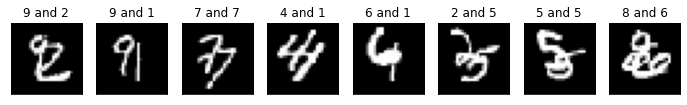

stop


In [7]:
from __future__ import print_function
import torch.utils.data as data
from PIL import Image
import os
import os.path
import errno
import numpy as np
import torch
import codecs
import scipy.misc as m
# Reproducibility
import random
random.seed(999)
np.random.seed(999)
torch.manual_seed(999)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

MNIST_DATA_FOLDER = './data/MultiMNIST/'

class MNIST(data.Dataset):
    """`MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
    Args:
        root (string): Root directory of dataset where ``processed/training.pt``
            and  ``processed/test.pt`` exist.
        train (bool, optional): If True, creates dataset from ``training.pt``,
            otherwise from ``test.pt``.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
    """
    urls = [
        'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz',
    ]
    raw_folder = 'raw'
    processed_folder = 'processed'
    training_file = 'training.pt'
    test_file = 'test.pt'
    multi_training_file = 'multi_training.pt'
    multi_test_file = 'multi_test.pt'

    def __init__(self, root, train=True, transform=None, target_transform=None, download=False, multi=False):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.multi = multi

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found.' +
                               ' You can use download=True to download it')

        if not self._check_multi_exists():
            raise RuntimeError('Multi Task extension not found.' +
                               ' You can use download=True to download it')


        if multi:
            if self.train:
                self.train_data, self.train_labels_l, self.train_labels_r = torch.load(
                    os.path.join(self.root, self.processed_folder, self.multi_training_file))
            else:
                self.test_data, self.test_labels_l, self.test_labels_r = torch.load(
                    os.path.join(self.root, self.processed_folder, self.multi_test_file))
        else:
            if self.train:
                self.train_data, self.train_labels = torch.load(
                    os.path.join(self.root, self.processed_folder, self.training_file))
            else:
                self.test_data, self.test_labels = torch.load(
                    os.path.join(self.root, self.processed_folder, self.test_file))


    def __getitem__(self, index):
        import matplotlib.pyplot as plt
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.multi:
            if self.train:
                img, target_l, target_r = self.train_data[index], self.train_labels_l[index], self.train_labels_r[index]
            else:
                img, target_l, target_r = self.test_data[index], self.test_labels_l[index], self.test_labels_r[index]
        else:
            if self.train:
                img, target = self.train_data[index], self.train_labels[index]
            else:
                img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy().astype(np.uint8), mode='L')
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        if self.multi:
            return img, target_l, target_r
        else:
            return img, target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_exists(self):
        return os.path.exists(os.path.join(self.root, self.processed_folder, self.training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.test_file))
    
    def _check_multi_exists(self):
        return  os.path.exists(os.path.join(self.root, self.processed_folder, self.multi_training_file)) and \
            os.path.exists(os.path.join(self.root, self.processed_folder, self.multi_test_file))

    def download(self):
        """Download the MNIST data if it doesn't exist in processed_folder already."""
        from six.moves import urllib
        import gzip

        if self._check_exists() and self._check_multi_exists():
            return

        # download files
        try:
            os.makedirs(os.path.join(self.root, self.raw_folder))
            os.makedirs(os.path.join(self.root, self.processed_folder))
        except OSError as e:
            if e.errno == errno.EEXIST:
                pass
            else:
                raise

        for url in self.urls:
            print('Downloading ' + url)
            data = urllib.request.urlopen(url)
            filename = url.rpartition('/')[2]
            file_path = os.path.join(self.root, self.raw_folder, filename)
            with open(file_path, 'wb') as f:
                f.write(data.read())
            with open(file_path.replace('.gz', ''), 'wb') as out_f, \
                    gzip.GzipFile(file_path) as zip_f:
                out_f.write(zip_f.read())
            os.unlink(file_path)

        # process and save as torch files
        print('Processing...')
        mnist_ims, multi_mnist_ims, extension = read_image_file(os.path.join(self.root, self.raw_folder, 'train-images-idx3-ubyte'))
        mnist_labels, multi_mnist_labels_l, multi_mnist_labels_r = read_label_file(os.path.join(self.root, self.raw_folder, 'train-labels-idx1-ubyte'), extension)

        tmnist_ims, tmulti_mnist_ims, textension = read_image_file(os.path.join(self.root, self.raw_folder, 't10k-images-idx3-ubyte'))
        tmnist_labels, tmulti_mnist_labels_l, tmulti_mnist_labels_r = read_label_file(os.path.join(self.root, self.raw_folder, 't10k-labels-idx1-ubyte'), textension)


        mnist_training_set = (mnist_ims, mnist_labels)
        multi_mnist_training_set = (multi_mnist_ims, multi_mnist_labels_l, multi_mnist_labels_r)

        mnist_test_set = (tmnist_ims, tmnist_labels)
        multi_mnist_test_set = (tmulti_mnist_ims, tmulti_mnist_labels_l, tmulti_mnist_labels_r)

        with open(os.path.join(self.root, self.processed_folder, self.training_file), 'wb') as f:
            torch.save(mnist_training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.test_file), 'wb') as f:
            torch.save(mnist_test_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.multi_training_file), 'wb') as f:
            torch.save(multi_mnist_training_set, f)
        with open(os.path.join(self.root, self.processed_folder, self.multi_test_file), 'wb') as f:
            torch.save(multi_mnist_test_set, f)
        print('Done!')

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'train' if self.train is True else 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str


def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)


def read_label_file(path, extension):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2049
        length = get_int(data[4:8])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
        multi_labels_l = np.zeros((1*length),dtype=np.long)
        multi_labels_r = np.zeros((1*length),dtype=np.long)
        for im_id in range(length):
            for rim in range(1):
                multi_labels_l[1*im_id+rim] = parsed[im_id]
                multi_labels_r[1*im_id+rim] = parsed[extension[1*im_id+rim]] 
        return torch.from_numpy(parsed).view(length).long(), torch.from_numpy(multi_labels_l).view(length*1).long(), torch.from_numpy(multi_labels_r).view(length*1).long()


def read_image_file(path):
    with open(path, 'rb') as f:
        data = f.read()
        assert get_int(data[:4]) == 2051
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        images = []
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        pv = parsed.reshape(length, num_rows, num_cols)
        multi_length = length * 1
        multi_data = np.zeros((1*length, num_rows, num_cols))
        extension = np.zeros(1*length, dtype=np.int32)
        for left in range(length):
            chosen_ones = np.random.permutation(length)[:1]
            extension[left*1:(left+1)*1] = chosen_ones
            for j, right in enumerate(chosen_ones):
                lim = pv[left,:,:]
                rim = pv[right,:,:]
                new_im = np.zeros((36,36))
                new_im[0:28,0:28] = lim
                new_im[6:34,6:34] = rim
                new_im[6:28,6:28] = np.maximum(lim[6:28,6:28], rim[0:22,0:22])
                multi_data_im = np.array(Image.fromarray(new_im).resize((28, 28), resample=Image.NEAREST)) 
                multi_data[left*1 + j,:,:] = multi_data_im
        return torch.from_numpy(parsed).view(length, num_rows, num_cols), torch.from_numpy(multi_data).view(length,num_rows, num_cols), extension

if __name__ == '__main__':
    import torch
    import torchvision
    import matplotlib.pyplot as plt
    from torchvision import transforms
    import matplotlib.pyplot as plt

    def global_transformer():
        return transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))])

    dst = MNIST(root=MNIST_DATA_FOLDER, train=True, download=True, transform=global_transformer(), multi=True)
    loader = torch.utils.data.DataLoader(dst, batch_size=8, shuffle=True, num_workers=4)
    for dat in loader:
        print('These are random examples from MultiMNIST dataset. Type \'stop\' to stop loader')
        ims = dat[0].view(8,28,28).numpy()

        labs_l = dat[1]
        labs_r = dat[2]
        f, axarr = plt.subplots(1,8, figsize=(12,1.5))
        for j in range(8):
            axarr[j].imshow(ims[j,:,:], cmap='gray')
            axarr[j].set_title(f'{labs_l[j]} and {labs_r[j]}')
            axarr[j].set_xticks([])
            axarr[j].set_yticks([])
        plt.savefig('multimnist_example.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
        plt.show()
        a = input()
        if a == 'stop':
            break
        else:
            plt.close()


# Model definition

In [8]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class MultiLeNetEnc(nn.Module):
    def __init__(self):
        super(MultiLeNetEnc, self).__init__()
        self.conv1   = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2   = nn.Conv2d(10, 20, kernel_size=5)
        self.dropout = nn.Dropout2d(p=0.2)
        self.fc      = nn.Linear(320, 50)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv2(x)
        x = self.dropout(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc(x))
        return x

class MultiLeNetDec(nn.Module):
    def __init__(self):
        super(MultiLeNetDec, self).__init__()
        self.fc1     = nn.Linear(50, 50)
        self.fc2     = nn.Linear(50, 10)
        self.dropout = nn.Dropout2d(p=0.2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

def get_model(params):
    model = {}
    model['enc'] = MultiLeNetEnc()
    model['enc'].cuda()
    if 'L' in params['tasks']:
        model['L'] = MultiLeNetDec()
        model['L'].cuda()
    if 'R' in params['tasks']:
        model['R'] = MultiLeNetDec()
        model['R'].cuda()
    return model

# Shared weights optimization

In [18]:
def bisection_direction(w1, w2):
    w1_norm = torch.norm(w1)
    w2_norm = torch.norm(w2)
    wandb.log({'g1 norm': w1_norm,
               'g2 norm': w2_norm})
    return (w1*w2_norm + w2*w1_norm)/(w1_norm + w2_norm)

def altitude_direction(w1, w2):
    w1_norm = torch.norm(w1)
    w2_norm = torch.norm(w2)
    wandb.log({'g1 norm': w1_norm,
               'g2 norm': w2_norm})
    if w1.T @ w2 >= w2.T @ w2:
        gamma = 1
    elif w1.T @ w2 >= w1.T @ w1:
        gamma = 0
    else:
        gamma = ((w2-w1).T @ w2)/((w2-w1).T @ (w2-w1))
    return gamma*w1 + (1-gamma)*w2

def altitude_gradient(grads1, grads2):
    g1 = torch.nn.utils.parameters_to_vector(grads1)
    g2 = torch.nn.utils.parameters_to_vector(grads2)
    g  = altitude_direction(g1, g2)
    torch.nn.utils.vector_to_parameters(g, grads1)
    return grads1

def bisection_gradient(grads1, grads2):
    g1 = torch.nn.utils.parameters_to_vector(grads1)
    g2 = torch.nn.utils.parameters_to_vector(grads2)
    g  = bisection_direction(g1, g2)
    torch.nn.utils.vector_to_parameters(g, grads1)
    return grads1

# Training

In [ ]:
from tqdm import tqdm
from tqdm.notebook import tqdm
## Ignore excessive warnings
# import logging
# logging.propagate = False 
# logging.getLogger().setLevel(logging.ERROR)
# import wandb

N_EPOCHS          = 100
N_DROP_LR         = 10
DROP_LR_FACTOR    = 0.3
MNIST_DATA_FOLDER = './data/MultiMNIST/'
BATCH_SIZE        = 256 
LEARNING_RATE_IN  = 5e-2
MOMENTUM          = 0.9
params = {}
params['tasks'] = ['L', 'R']
models = get_model(params)
wandb.config.n_epochs       = N_EPOCHS
wandb.config.n_drop_lr      = N_DROP_LR
wandb.config.drop_lr_factor = DROP_LR_FACTOR
wandb.config.batch_size     = BATCH_SIZE
wandb.config.initial_lr     = LEARNING_RATE_IN
wandb.config.momentum       = MOMENTUM

train_dst = MNIST(root=MNIST_DATA_FOLDER, train=True, download=True, transform=global_transformer(), multi=True)
train_loader = torch.utils.data.DataLoader(train_dst, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_dst = MNIST(root=MNIST_DATA_FOLDER, train=False, download=True, transform=global_transformer(), multi=True)
val_loader = torch.utils.data.DataLoader(val_dst, batch_size=100, shuffle=True, num_workers=4)

# Metrics
list_of_methods = ['EDM','MGDA']
methods = {}
for method in list_of_methods:
    methods[method] = {}
    methods[method]['train_acc_l']  = []
    methods[method]['test_acc_l']   = []
    methods[method]['train_loss_l'] = []
    methods[method]['test_loss_l']  = []
    methods[method]['train_acc_r']  = []
    methods[method]['test_acc_r']   = []
    methods[method]['train_loss_r'] = []
    methods[method]['test_loss_r']  = []
    methods[method]['train_loss_t'] = []
    methods[method]['test_loss_t']  = []

for method in list_of_methods:
    wandb.init(project="MultiMNIST", name=method)
    models = get_model(params)
    criterion = torch.nn.NLLLoss()
    n_iter = 0
    LEARNING_RATE = LEARNING_RATE_IN
    optimizers = {}
    schedulers = {}
    for m in models:
        if m == 'enc':
            continue
        optimizers[m] = torch.optim.SGD(models[m].parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
        schedulers[m] = torch.optim.lr_scheduler.StepLR(optimizers[m], step_size=N_DROP_LR, gamma=DROP_LR_FACTOR)

    print(f'🤖 MultiMNIST training with {method}.')
    for i_epoch in tqdm(range(N_EPOCHS)):
        if i_epoch > 0 and i_epoch % N_DROP_LR == 0:
            LEARNING_RATE *= DROP_LR_FACTOR 
        train_acc_l, n_train, test_acc_l, n_test = 0, 0, 0, 0
        train_acc_r, test_acc_r                  = 0, 0
        for m in models:
                models[m].train()

        for batch in train_loader:
            n_iter += 1
            # Here can be problems with single task setup
            images, labs_l, labs_r = batch
            images, labs_l, labs_r = Variable(images.cuda()), Variable(labs_l.cuda()), Variable(labs_r.cuda())

            for m in models:
                models[m].zero_grad()
                if m == 'enc':
                    continue
                optimizers[m].zero_grad()  
            
            # Encoder output
            Z   = models['enc'](images)
            
            # Task - specific outputs
            Y_l = models['L'](Z)
            Y_r = models['R'](Z)

            # Task-specific losses
            loss_l = criterion(Y_l, labs_l)
            predictions_l = Y_l.data.max(1, keepdim=True)[1]
            train_acc_l   += (predictions_l.eq(labs_l.data.view_as(predictions_l)).cpu().sum())
            n_train       += predictions_l.shape[0]
            grads_l = torch.autograd.grad(loss_l, models['enc'].parameters(), retain_graph=True)

            loss_l.backward(retain_graph=True)
            optimizers['L'].step()
            schedulers['L'].step()
            optimizers['L'].zero_grad()
            for parameter in models['enc'].parameters():
                if parameter.grad is not None:
                    parameter.grad.data.zero_()

            loss_r = criterion(Y_r, labs_r)
            predictions_r = Y_r.data.max(1, keepdim=True)[1]
            train_acc_r   += (predictions_r.eq(labs_r.data.view_as(predictions_r)).cpu().sum())
            grads_r = torch.autograd.grad(loss_r, models['enc'].parameters(), retain_graph=True)
        
            loss_r.backward(retain_graph=True)
            optimizers['R'].step()
            schedulers['R'].step()
            optimizers['R'].zero_grad()
            for parameter in models['enc'].parameters():
                if parameter.grad is not None:
                    parameter.grad.data.zero_()

            # Updating shared weights
            if method == 'EDM':
                edm_grads = bisection_gradient(grads_l, grads_r)
                PRO_LR = LEARNING_RATE
            elif method == 'MGDA':
                PRO_LR = LEARNING_RATE
                edm_grads = altitude_gradient(grads_l, grads_r)
            for i_par, parameter in enumerate(models['enc'].parameters()):
                parameter.data = parameter.data - PRO_LR*edm_grads[i_par].data
            
            methods[method]['train_loss_l'].append(loss_l.data)
            methods[method]['train_loss_r'].append(loss_r.data)
            wandb.log({'train_loss_L': loss_l.data,
                       'train_loss_R': loss_r.data,
                       'Iterations': n_iter})
        train_acc_l, train_acc_r = float(train_acc_l)/n_train, float(train_acc_r)/n_train
        methods[method]['train_acc_l'].append(train_acc_l)
        methods[method]['train_acc_r'].append(train_acc_r)
        wandb.log({'train_acc_L': train_acc_l,
                   'train_acc_R': train_acc_r})

        for m in models:
            models[m].eval()
        
        for batch in val_loader:
            # Here can be problems with single task setup
            images, labs_l, labs_r = batch
            images, labs_l, labs_r = Variable(images.cuda()), Variable(labs_l.cuda()), Variable(labs_r.cuda())
            
            # Encoder output
            Z   = models['enc'](images)
            
            # Task - specific outputs
            Y_l = models['L'](Z)
            Y_r = models['R'](Z)

            # Task-specific losses
            loss_l = criterion(Y_l, labs_l)
            predictions_l = Y_l.data.max(1, keepdim=True)[1]
            test_acc_l   += (predictions_l.eq(labs_l.data.view_as(predictions_l)).cpu().sum())
            n_test       += predictions_l.shape[0]

            loss_r = criterion(Y_r, labs_r)
            predictions_r = Y_r.data.max(1, keepdim=True)[1]
            test_acc_r   += (predictions_r.eq(labs_r.data.view_as(predictions_r)).cpu().sum())
            
        test_acc_l, test_acc_r = float(test_acc_l)/n_test, float(test_acc_r)/n_test
        methods[method]['test_loss_l'].append(loss_l.data)
        methods[method]['test_loss_r'].append(loss_r.data)
        methods[method]['test_acc_l'].append(test_acc_l)
        methods[method]['test_acc_r'].append(test_acc_r)
        wandb.log({'test_loss_L': loss_l.data,
                   'test_loss_R': loss_r.data})
        wandb.log({'test_acc_L': test_acc_l,
                   'test_acc_R': test_acc_r,
                   'Epoch': i_epoch+1,
                   'Learning rate': PRO_LR})

🤖 MultiMNIST training with EDM.


Exception in thread Thread-741:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/wandb/apis/file_stream.py", line 213, in _thread_body
    self._send(ready_chunks)
  File "/usr/local/lib/python3.6/dist-packages/wandb/apis/file_stream.py", line 249, in _send
    self._client.post, self._endpoint, json={'files': files}))
  File "/usr/local/lib/python3.6/dist-packages/wandb/apis/file_stream.py", line 227, in _handle_response
    raise response
  File "/usr/local/lib/python3.6/dist-packages/wandb/util.py", line 608, in request_with_retry
    response.raise_for_status()
  File "/usr/local/lib/python3.6/dist-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not F

In [ ]:
def plot_metrics(methods, title = 'MultiMNIST'):
    colors = ['r', 'g', 'b']
    color_labels = ['^', 'o', '-']
    fig, axs = plt.subplots(2, 4, figsize = (16,8))
    ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = [ax for row in axs for ax in row]
    fig.suptitle(title)
    losses_trains_l = [methods[method]['train_loss_l'] for method in methods]
    losses_tests_l  = [methods[method]['test_loss_l'] for method in methods]
    acc_trains_l    = [methods[method]['train_acc_l'] for method in methods]
    acc_tests_l     = [methods[method]['test_acc_l'] for method in methods]
    losses_trains_r = [methods[method]['train_loss_r'] for method in methods]
    losses_tests_r  = [methods[method]['test_loss_r'] for method in methods]
    acc_trains_r    = [methods[method]['train_acc_r'] for method in methods]
    acc_tests_r     = [methods[method]['test_acc_r'] for method in methods]
    
    for losses_train_l, losses_test_l, acc_train_l, acc_test_l, \
        losses_train_r, losses_test_r, acc_train_r, acc_test_r, label, col, col_lab \
        in \
        zip(losses_trains_l, losses_tests_l, acc_trains_l, acc_tests_l, \
            losses_trains_r, losses_tests_r, acc_trains_r, acc_tests_r, methods, colors, color_labels):
        # ax1.semilogy(losses_train_l, col+col_lab, label = label)
        ax1.semilogy(losses_train_l, col)
        ax2.semilogy(losses_test_l,  col+col_lab, label = label)
        ax2.semilogy(losses_test_l,  col+':')
        ax3.plot(acc_train_l, col+col_lab, label = label)
        ax3.plot(acc_train_l, col+':')
        ax4.plot(acc_test_l,  col+col_lab, label = label)
        ax4.plot(acc_test_l,  col+':')
        # ax5.semilogy(losses_train_r, col+col_lab, label = label)
        ax5.semilogy(losses_train_r, col)
        ax6.semilogy(losses_test_r,  col+col_lab, label = label)
        ax6.semilogy(losses_test_r,  col+':')
        ax7.plot(acc_train_r, col+col_lab, label = label)
        ax7.plot(acc_train_r, col+':')
        ax8.plot(acc_test_r,  col+col_lab, label = label)
        ax8.plot(acc_test_r,  col+':')
    ax1.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax1.set_title('Train loss. L')
    ax1.set_xlabel('Iterations')
    ax3.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax3.set_title('Train accuracy. L')
    ax3.set_xlabel('Epochs')
    ax2.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax2.set_title('Test loss. L')
    ax2.set_xlabel('Epochs')
    ax4.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax4.set_title('Test accuracy. L')
    ax4.set_xlabel('Epochs')
    ax5.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax5.set_title('Train loss. R')
    ax5.set_xlabel('Iterations')
    ax7.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax7.set_title('Train accuracy. R')
    ax7.set_xlabel('Epochs')
    ax6.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax6.set_title('Test loss. R')
    ax6.set_xlabel('Epochs')
    ax8.grid(True,which="both", linestyle='--', linewidth=0.4)
    ax8.set_title('Test accuracy. R')
    ax8.set_xlabel('Epochs')
    plt.legend()
    fig.tight_layout()
    plt.savefig(title + '.pdf')
    plt.show()

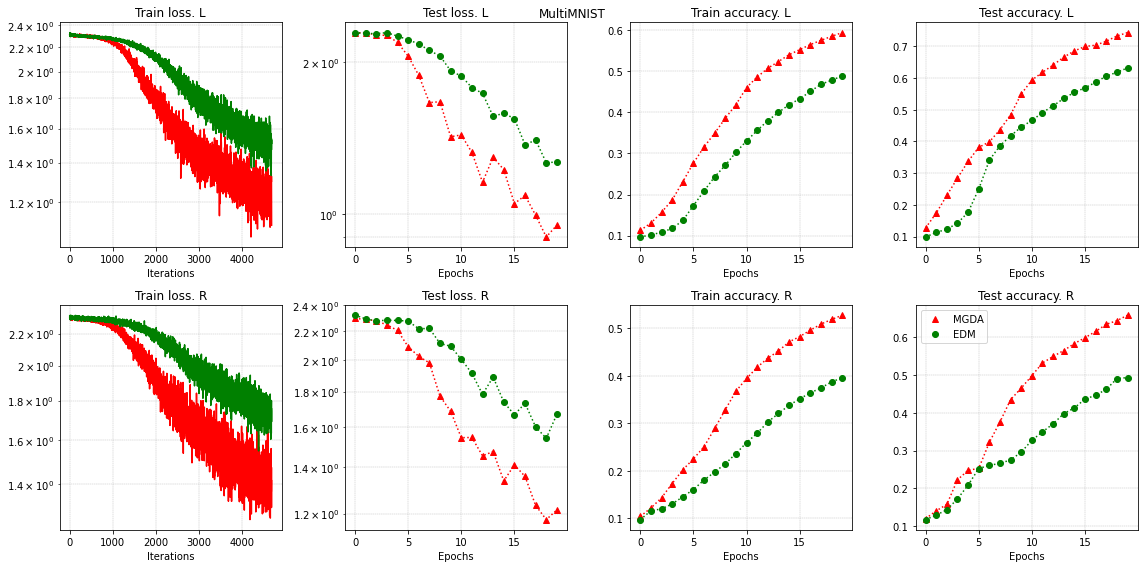

In [ ]:
plot_metrics(methods)